In [1]:
import pandas as pd
import glob
import os

# Percorso ai file CSV delle strategie
csv_files = glob.glob("./DATA/*.csv")

# Funzione per leggere e pulire ogni file
frames = []
for file in csv_files:
    # Estraggo il nome strategia dal nome file
    strategy = os.path.basename(file).replace('.csv', '')
    # Leggo il file gestendo possibili codifiche e separatori
    try:
        df = pd.read_csv(file, sep='\t', encoding='utf-16', engine='python')
    except Exception:
        df = pd.read_csv(file, sep='\t', encoding='utf-8', engine='python')
    # Rimuovo eventuali colonne con nomi strani
    df.columns = [c.strip('<> \r\n\t').upper() for c in df.columns]
    # Prendo solo DATE e BALANCE
    df = df[[col for col in df.columns if 'DATE' in col or 'BALANCE' in col]]
    # Rinomino le colonne
    df = df.rename(columns={df.columns[0]: 'DATE', df.columns[1]: f'BALANCE_{strategy}'})
    # Pulizia e conversione timestamp
    df['DATE'] = df['DATE'].astype(str).str.strip()
    frames.append(df)

# Merge progressivo su DATE
from functools import reduce
merged = reduce(lambda left, right: pd.merge(left, right, on='DATE', how='outer'), frames)

# Ordina per data
merged = merged.sort_values('DATE').reset_index(drop=True)

# Mostra le prime righe
merged.head()

,DATE,"BALANCE_usdcad_1m_1440,1","BALANCE_usdcad_15m_1440,0.1","BALANCE_usdcad_5m_120,2","BALANCE_usdcad_1m_120,2","BALANCE_usdcad_1m_7200,0.5","BALANCE_usdcad_5m_1440,0.5"
0,2024.01.01 00:00,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
1,2024.01.02 00:26,10018.1,NaN,NaN,NaN,10021.6,NaN
2,2024.01.02 00:31,NaN,NaN,NaN,NaN,NaN,10024.4
3,2024.01.02 03:04,10018.1,NaN,NaN,NaN,NaN,NaN
4,2024.01.02 03:05,10018.1,NaN,NaN,NaN,10021.6,NaN


In [2]:
# Applica forward fill per gestire i mismatch temporali
merged_ffill = merged.ffill()
merged_ffill.head()

,DATE,"BALANCE_usdcad_1m_1440,1","BALANCE_usdcad_15m_1440,0.1","BALANCE_usdcad_5m_120,2","BALANCE_usdcad_1m_120,2","BALANCE_usdcad_1m_7200,0.5","BALANCE_usdcad_5m_1440,0.5"
0,2024.01.01 00:00,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
1,2024.01.02 00:26,10018.1,10000.0,10000.0,10000.0,10021.6,10000.0
2,2024.01.02 00:31,10018.1,10000.0,10000.0,10000.0,10021.6,10024.4
3,2024.01.02 03:04,10018.1,10000.0,10000.0,10000.0,10021.6,10024.4
4,2024.01.02 03:05,10018.1,10000.0,10000.0,10000.0,10021.6,10024.4


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Conversione timestamp in datetime
merged_ffill['DATE'] = pd.to_datetime(merged_ffill['DATE'], format='%Y.%m.%d %H:%M')

# Ordina per data
merged_ffill = merged_ffill.sort_values('DATE').reset_index(drop=True)

# Estrarre solo le colonne BALANCE
balance_cols = [col for col in merged_ffill.columns if 'BALANCE' in col]
print(f"Strategie trovate: {len(balance_cols)}")
print(f"Colonne balance: {balance_cols}")

# Visualizza il range temporale
print(f"Periodo: {merged_ffill['DATE'].min()} - {merged_ffill['DATE'].max()}")
print(f"Numero di osservazioni: {len(merged_ffill)}")

merged_ffill.head()

Strategie trovate: 6
Colonne balance: ['BALANCE_usdcad_1m_1440,1', 'BALANCE_usdcad_15m_1440,0.1', 'BALANCE_usdcad_5m_120,2', 'BALANCE_usdcad_1m_120,2', 'BALANCE_usdcad_1m_7200,0.5', 'BALANCE_usdcad_5m_1440,0.5']
Periodo: 2024-01-01 00:00:00 - 2025-07-04 23:58:00
Numero di osservazioni: 19707


,DATE,"BALANCE_usdcad_1m_1440,1","BALANCE_usdcad_15m_1440,0.1","BALANCE_usdcad_5m_120,2","BALANCE_usdcad_1m_120,2","BALANCE_usdcad_1m_7200,0.5","BALANCE_usdcad_5m_1440,0.5"
0,2024-01-01 00:00:00,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
1,2024-01-02 00:26:00,10018.1,10000.0,10000.0,10000.0,10021.6,10000.0
2,2024-01-02 00:31:00,10018.1,10000.0,10000.0,10000.0,10021.6,10024.4
3,2024-01-02 03:04:00,10018.1,10000.0,10000.0,10000.0,10021.6,10024.4
4,2024-01-02 03:05:00,10018.1,10000.0,10000.0,10000.0,10021.6,10024.4


In [4]:
def dynamic_rebalance_portfolio(df, balance_cols, rebalance_threshold=0.05, rebalance_freq='W'):
    """
    Implementa un portafoglio con ribilanciamento dinamico basato sulla performance settimanale.
    
    Parameters:
    - df: DataFrame con DATE e colonne BALANCE
    - balance_cols: lista delle colonne balance
    - rebalance_threshold: percentuale da redistribuire (0.05 = 5%)
    - rebalance_freq: frequenza di ribilanciamento ('W' = settimanale)
    """
    
    # Copia del DataFrame
    data = df.copy()
    n_strategies = len(balance_cols)
    
    # Inizializza pesi uguali per tutte le strategie
    initial_weight = 1.0 / n_strategies
    weights = pd.DataFrame(index=data.index, columns=balance_cols)
    weights.iloc[0] = initial_weight
    
    # Calcola i rendimenti normalizzati (da 10000 iniziale)
    returns_df = data[balance_cols].pct_change().fillna(0)
    
    # Traccia la performance settimanale
    weekly_performance = []
    rebalance_dates = []
    
    # Variabili per il portafoglio
    portfolio_value = [10000.0]  # Valore iniziale del portafoglio
    current_weights = np.array([initial_weight] * n_strategies)
    
    # Resample per settimane (usando l'ultimo valore di ogni settimana)
    weekly_data = data.set_index('DATE').resample('W').last()
    
    for i in range(1, len(data)):
        current_date = data.iloc[i]['DATE']
        
        # Mantieni i pesi precedenti
        weights.iloc[i] = current_weights
        
        # Calcola il nuovo valore del portafoglio
        strategy_returns = returns_df.iloc[i].values
        portfolio_return = np.sum(current_weights * strategy_returns)
        new_portfolio_value = portfolio_value[-1] * (1 + portfolio_return)
        portfolio_value.append(new_portfolio_value)
        
        # Verifica se è time di ribilanciamento (ogni lunedì)
        if current_date.weekday() == 0 and i > 7:  # Lunedì e dopo almeno una settimana
            # Calcola performance della settimana precedente
            week_ago_idx = max(0, i - 7)
            week_performance = {}
            
            for col in balance_cols:
                start_val = data.iloc[week_ago_idx][col]
                end_val = data.iloc[i-1][col]  # Usa i-1 per evitare lookahead bias
                
                if start_val != 0:
                    perf = (end_val - start_val) / start_val
                    week_performance[col] = perf
                else:
                    week_performance[col] = 0
            
            # Ordina per performance
            sorted_strategies = sorted(week_performance.items(), key=lambda x: x[1], reverse=True)
            
            # Prendi le top 5 e le worst 5 (o meno se ci sono meno strategie)
            n_top = min(5, len(sorted_strategies))
            n_worst = min(5, len(sorted_strategies))
            
            top_strategies = [s[0] for s in sorted_strategies[:n_top]]
            worst_strategies = [s[0] for s in sorted_strategies[-n_worst:]]
            
            # Calcola i nuovi pesi
            new_weights = current_weights.copy()
            
            # Rimuovi peso dalle strategie peggiori
            total_removed = 0
            for col in worst_strategies:
                if col in balance_cols:
                    idx = balance_cols.index(col)
                    reduction = min(rebalance_threshold / n_worst, new_weights[idx] * 0.5)  # Max 50% reduction
                    new_weights[idx] -= reduction
                    total_removed += reduction
            
            # Aggiungi peso alle strategie migliori
            for col in top_strategies:
                if col in balance_cols:
                    idx = balance_cols.index(col)
                    new_weights[idx] += total_removed / n_top
            
            # Normalizza i pesi per assicurarsi che sommino a 1
            new_weights = new_weights / np.sum(new_weights)
            current_weights = new_weights
            
            # Salva per analisi
            weekly_performance.append({
                'date': current_date,
                'top_strategies': top_strategies,
                'worst_strategies': worst_strategies,
                'performance': week_performance
            })
            rebalance_dates.append(current_date)
    
    # Crea DataFrame dei risultati
    weights_df = pd.DataFrame(weights.values, columns=balance_cols, index=data['DATE'])
    portfolio_df = pd.DataFrame({
        'DATE': data['DATE'],
        'PORTFOLIO_VALUE': portfolio_value
    })
    
    return portfolio_df, weights_df, weekly_performance, rebalance_dates

# Test con threshold di esempio
portfolio_result, weights_result, weekly_perf, rebal_dates = dynamic_rebalance_portfolio(
    merged_ffill, balance_cols, rebalance_threshold=0.05
)

print(f"Portafoglio creato! Valore finale: ${portfolio_result['PORTFOLIO_VALUE'].iloc[-1]:.2f}")
print(f"Numero di ribilanciamenti: {len(rebal_dates)}")
portfolio_result.tail()

Portafoglio creato! Valore finale: $11206.43
Numero di ribilanciamenti: 3841


,DATE,PORTFOLIO_VALUE
19702,2025-07-04 23:38:00,11229.919960
19703,2025-07-04 23:38:00,11229.919960
19704,2025-07-04 23:48:00,11229.911395
19705,2025-07-04 23:57:00,11229.911395
19706,2025-07-04 23:58:00,11206.433971


In [5]:
def grid_search_rebalance_threshold(df, balance_cols, threshold_range=np.arange(0.01, 0.20, 0.01)):
    """
    Esegue grid search per trovare il threshold ottimale di ribilanciamento.
    """
    results = []
    
    print(f"Testando {len(threshold_range)} valori di threshold...")
    
    for i, threshold in enumerate(threshold_range):
        print(f"Progresso: {i+1}/{len(threshold_range)} - Threshold: {threshold:.3f}", end='\r')
        
        try:
            portfolio_df, weights_df, weekly_perf, rebal_dates = dynamic_rebalance_portfolio(
                df, balance_cols, rebalance_threshold=threshold
            )
            
            # Calcola metriche di performance
            final_value = portfolio_df['PORTFOLIO_VALUE'].iloc[-1]
            initial_value = portfolio_df['PORTFOLIO_VALUE'].iloc[0]
            total_return = (final_value - initial_value) / initial_value
            
            # Calcola Sharpe ratio (approssimativo)
            returns = portfolio_df['PORTFOLIO_VALUE'].pct_change().dropna()
            sharpe = returns.mean() / returns.std() * np.sqrt(252*24*60) if returns.std() > 0 else 0
            
            # Calcola max drawdown
            portfolio_df['PEAK'] = portfolio_df['PORTFOLIO_VALUE'].cummax()
            portfolio_df['DRAWDOWN'] = (portfolio_df['PORTFOLIO_VALUE'] - portfolio_df['PEAK']) / portfolio_df['PEAK']
            max_drawdown = portfolio_df['DRAWDOWN'].min()
            
            # Numero di ribilanciamenti
            num_rebalances = len(rebal_dates)
            
            results.append({
                'threshold': threshold,
                'final_value': final_value,
                'total_return': total_return,
                'sharpe_ratio': sharpe,
                'max_drawdown': max_drawdown,
                'num_rebalances': num_rebalances
            })
            
        except Exception as e:
            print(f"Errore con threshold {threshold}: {e}")
            continue
    
    print(f"\nGrid search completato! Testati {len(results)} parametri.")
    return pd.DataFrame(results)

# Esegui grid search
print("Inizio ottimizzazione threshold...")
optimization_results = grid_search_rebalance_threshold(
    merged_ffill, balance_cols, 
    threshold_range=np.arange(0.01, 0.15, 0.01)
)

# Trova il miglior threshold
best_result = optimization_results.loc[optimization_results['total_return'].idxmax()]
print(f"\nMiglior threshold: {best_result['threshold']:.3f}")
print(f"Ritorno totale: {best_result['total_return']:.2%}")
print(f"Sharpe ratio: {best_result['sharpe_ratio']:.3f}")
print(f"Max drawdown: {best_result['max_drawdown']:.2%}")

optimization_results.head(10)

Inizio ottimizzazione threshold...
Testando 14 valori di threshold...
Progresso: 14/14 - Threshold: 0.140
Grid search completato! Testati 14 parametri.

Miglior threshold: 0.020
Ritorno totale: 12.90%
Sharpe ratio: 7.906
Max drawdown: -3.88%


,threshold,final_value,total_return,sharpe_ratio,max_drawdown,num_rebalances
0,0.01,11202.600345,0.120260,7.854143,-0.036404,3841
1,0.02,11290.312975,0.129031,7.905726,-0.038776,3841
2,0.03,11261.885943,0.126189,7.826796,-0.037548,3841
3,0.04,11232.203397,0.123220,7.825010,-0.036397,3841
4,0.05,11206.433971,0.120643,7.886261,-0.036096,3841
5,0.06,11175.928036,0.117593,7.939556,-0.035794,3841
6,0.07,11140.825527,0.114083,7.942778,-0.035494,3841
7,0.08,11110.831727,0.111083,7.962413,-0.035193,3841
8,0.09,11094.486042,0.109449,8.059280,-0.034893,3841
9,0.10,11084.432040,0.108443,8.186466,-0.034595,3841


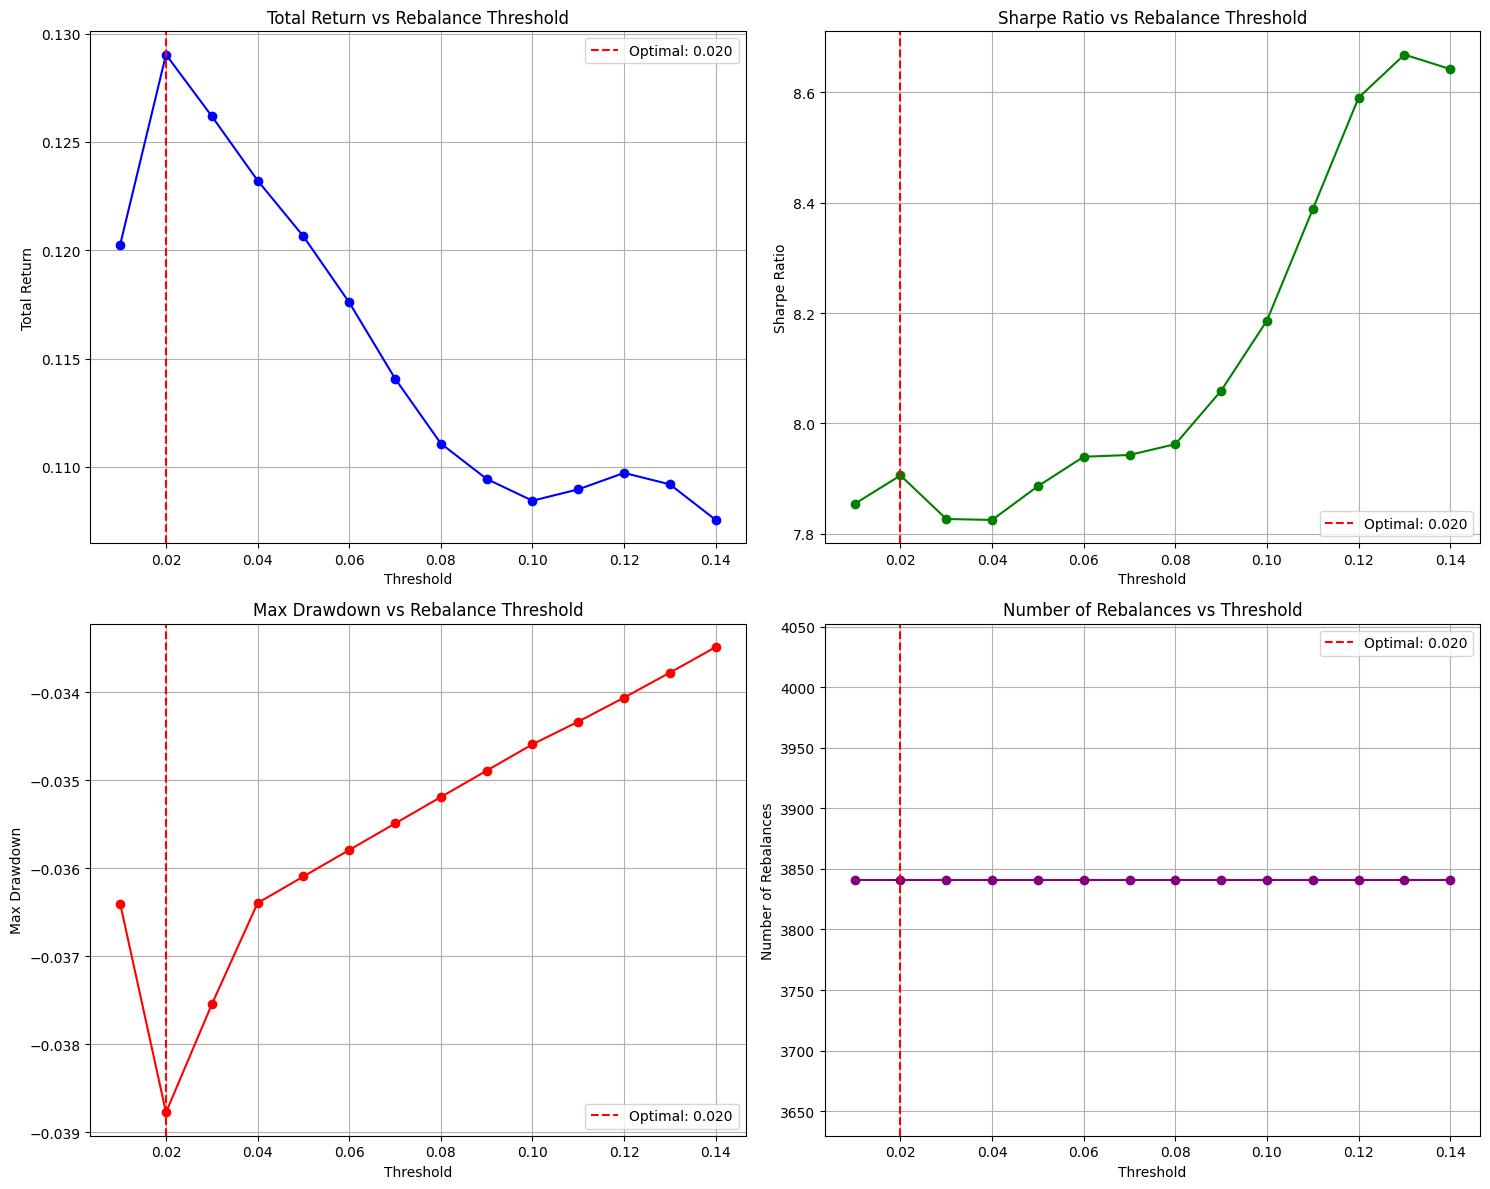


Creazione del portafoglio ottimale con threshold = 0.020
Portafoglio ottimale creato!
Valore finale: $11290.31
Ritorno totale: 12.90%
Numero di ribilanciamenti: 3841


,DATE,PORTFOLIO_VALUE
19702,2025-07-04 23:38:00,11313.679031
19703,2025-07-04 23:38:00,11313.679031
19704,2025-07-04 23:48:00,11313.675579
19705,2025-07-04 23:57:00,11313.675579
19706,2025-07-04 23:58:00,11290.312975


In [6]:
# Visualizzazione dei risultati del grid search
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Total Return vs Threshold
axes[0, 0].plot(optimization_results['threshold'], optimization_results['total_return'], 'b-o')
axes[0, 0].set_title('Total Return vs Rebalance Threshold')
axes[0, 0].set_xlabel('Threshold')
axes[0, 0].set_ylabel('Total Return')
axes[0, 0].grid(True)
axes[0, 0].axvline(x=best_result['threshold'], color='r', linestyle='--', label=f'Optimal: {best_result["threshold"]:.3f}')
axes[0, 0].legend()

# 2. Sharpe Ratio vs Threshold
axes[0, 1].plot(optimization_results['threshold'], optimization_results['sharpe_ratio'], 'g-o')
axes[0, 1].set_title('Sharpe Ratio vs Rebalance Threshold')
axes[0, 1].set_xlabel('Threshold')
axes[0, 1].set_ylabel('Sharpe Ratio')
axes[0, 1].grid(True)
axes[0, 1].axvline(x=best_result['threshold'], color='r', linestyle='--', label=f'Optimal: {best_result["threshold"]:.3f}')
axes[0, 1].legend()

# 3. Max Drawdown vs Threshold
axes[1, 0].plot(optimization_results['threshold'], optimization_results['max_drawdown'], 'r-o')
axes[1, 0].set_title('Max Drawdown vs Rebalance Threshold')
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('Max Drawdown')
axes[1, 0].grid(True)
axes[1, 0].axvline(x=best_result['threshold'], color='r', linestyle='--', label=f'Optimal: {best_result["threshold"]:.3f}')
axes[1, 0].legend()

# 4. Number of Rebalances vs Threshold
axes[1, 1].plot(optimization_results['threshold'], optimization_results['num_rebalances'], 'purple', marker='o')
axes[1, 1].set_title('Number of Rebalances vs Threshold')
axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('Number of Rebalances')
axes[1, 1].grid(True)
axes[1, 1].axvline(x=best_result['threshold'], color='r', linestyle='--', label=f'Optimal: {best_result["threshold"]:.3f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Crea il portafoglio ottimale
print(f"\nCreazione del portafoglio ottimale con threshold = {best_result['threshold']:.3f}")
optimal_portfolio, optimal_weights, optimal_weekly_perf, optimal_rebal_dates = dynamic_rebalance_portfolio(
    merged_ffill, balance_cols, rebalance_threshold=best_result['threshold']
)

print(f"Portafoglio ottimale creato!")
print(f"Valore finale: ${optimal_portfolio['PORTFOLIO_VALUE'].iloc[-1]:.2f}")
print(f"Ritorno totale: {((optimal_portfolio['PORTFOLIO_VALUE'].iloc[-1] / 10000) - 1):.2%}")
print(f"Numero di ribilanciamenti: {len(optimal_rebal_dates)}")

optimal_portfolio.tail()

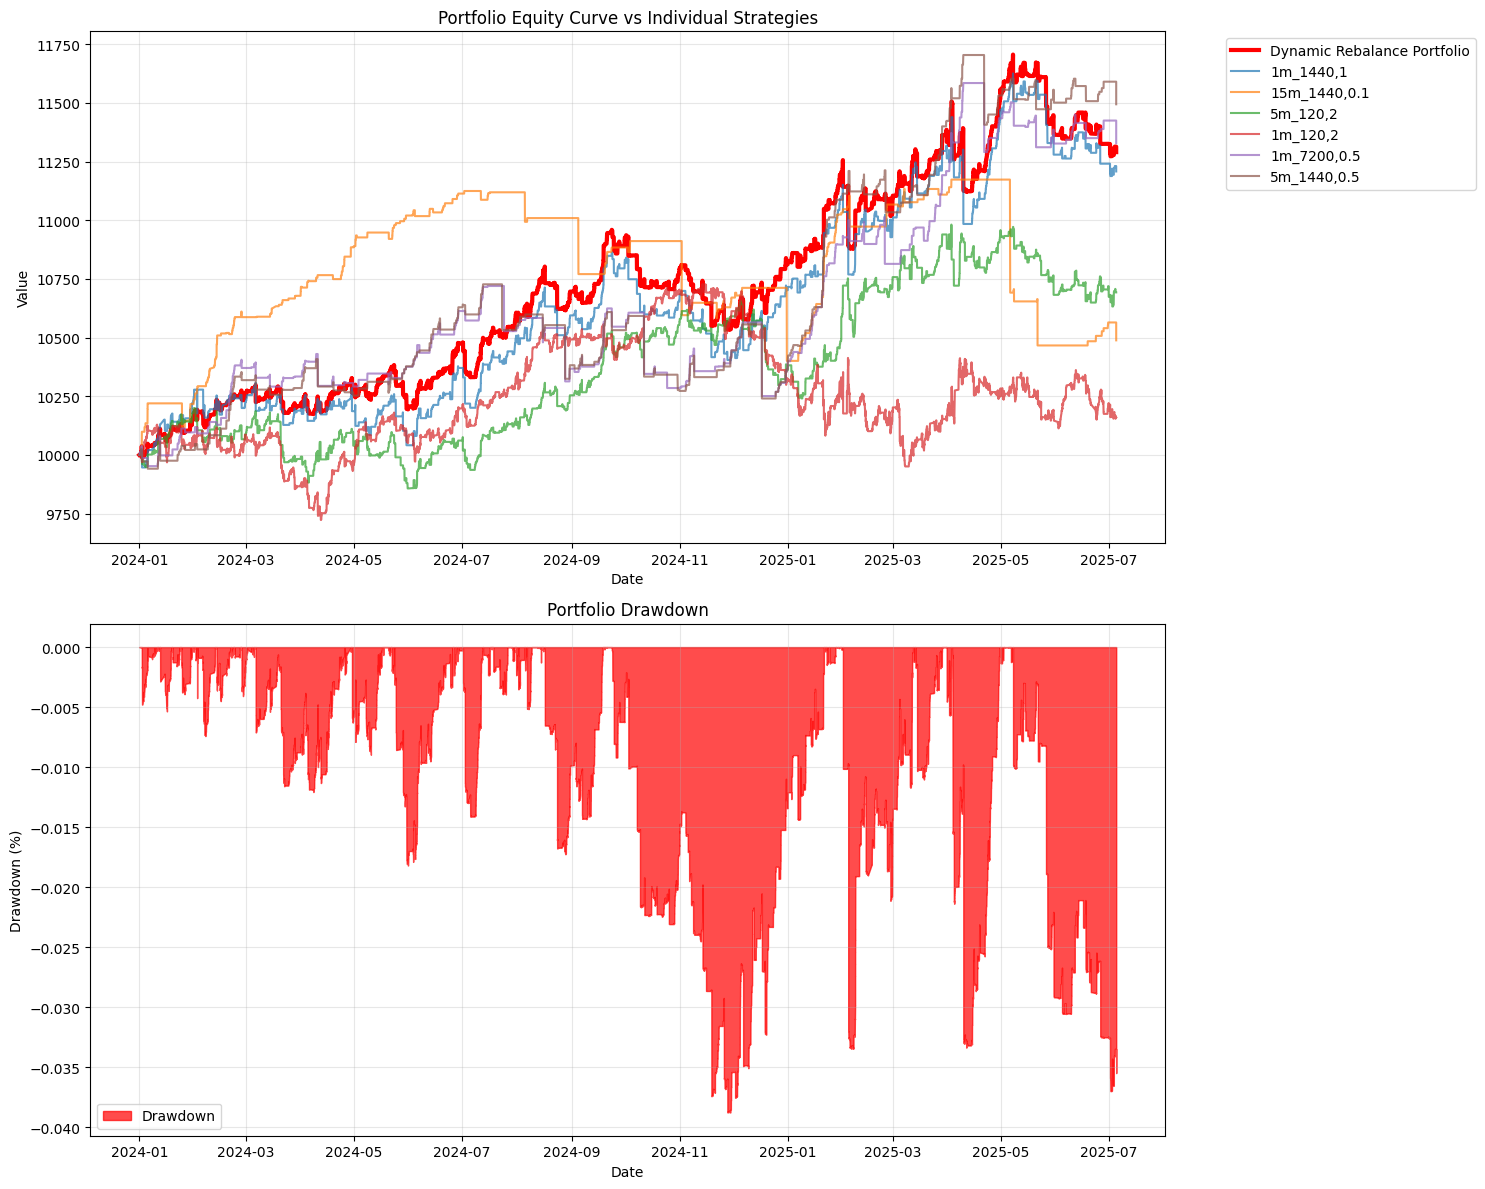

=== PERFORMANCE STATISTICS ===
Valore iniziale: $10,000.00
Valore finale: $11,290.31
Ritorno totale: 12.90%
Max drawdown: -3.88%
Numero di ribilanciamenti: 3841

=== COMPARISON WITH INDIVIDUAL STRATEGIES ===
1m_1440,1: 12.08%
15m_1440,0.1: 4.88%
5m_120,2: 6.93%
1m_120,2: 1.60%
1m_7200,0.5: 13.29%
5m_1440,0.5: 14.94%
Dynamic Portfolio: 12.90%


In [7]:
# Visualizzazione dell'equity curve del portafoglio ottimale
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# 1. Equity Curve del Portafoglio vs Strategie Individuali
axes[0].plot(optimal_portfolio['DATE'], optimal_portfolio['PORTFOLIO_VALUE'], 
             linewidth=3, color='red', label='Dynamic Rebalance Portfolio')

# Aggiungi le strategie individuali per confronto
for col in balance_cols:
    strategy_name = col.replace('BALANCE_', '').replace('usdcad_', '')
    axes[0].plot(merged_ffill['DATE'], merged_ffill[col], 
                alpha=0.7, label=strategy_name)

axes[0].set_title('Portfolio Equity Curve vs Individual Strategies')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Value')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True, alpha=0.3)

# 2. Drawdown del Portafoglio
optimal_portfolio['PEAK'] = optimal_portfolio['PORTFOLIO_VALUE'].cummax()
optimal_portfolio['DRAWDOWN'] = (optimal_portfolio['PORTFOLIO_VALUE'] - optimal_portfolio['PEAK']) / optimal_portfolio['PEAK']

axes[1].fill_between(optimal_portfolio['DATE'], optimal_portfolio['DRAWDOWN'], 0, 
                    alpha=0.7, color='red', label='Drawdown')
axes[1].set_title('Portfolio Drawdown')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Drawdown (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistiche di performance del portafoglio
print("=== PERFORMANCE STATISTICS ===")
print(f"Valore iniziale: ${optimal_portfolio['PORTFOLIO_VALUE'].iloc[0]:,.2f}")
print(f"Valore finale: ${optimal_portfolio['PORTFOLIO_VALUE'].iloc[-1]:,.2f}")
print(f"Ritorno totale: {((optimal_portfolio['PORTFOLIO_VALUE'].iloc[-1] / optimal_portfolio['PORTFOLIO_VALUE'].iloc[0]) - 1):.2%}")
print(f"Max drawdown: {optimal_portfolio['DRAWDOWN'].min():.2%}")
print(f"Numero di ribilanciamenti: {len(optimal_rebal_dates)}")

# Confronto con le strategie individuali
print("\n=== COMPARISON WITH INDIVIDUAL STRATEGIES ===")
for col in balance_cols:
    strategy_name = col.replace('BALANCE_', '').replace('usdcad_', '')
    initial_val = merged_ffill[col].iloc[0]
    final_val = merged_ffill[col].iloc[-1]
    strategy_return = (final_val - initial_val) / initial_val
    print(f"{strategy_name}: {strategy_return:.2%}")

portfolio_return = (optimal_portfolio['PORTFOLIO_VALUE'].iloc[-1] / optimal_portfolio['PORTFOLIO_VALUE'].iloc[0]) - 1
print(f"Dynamic Portfolio: {portfolio_return:.2%}")

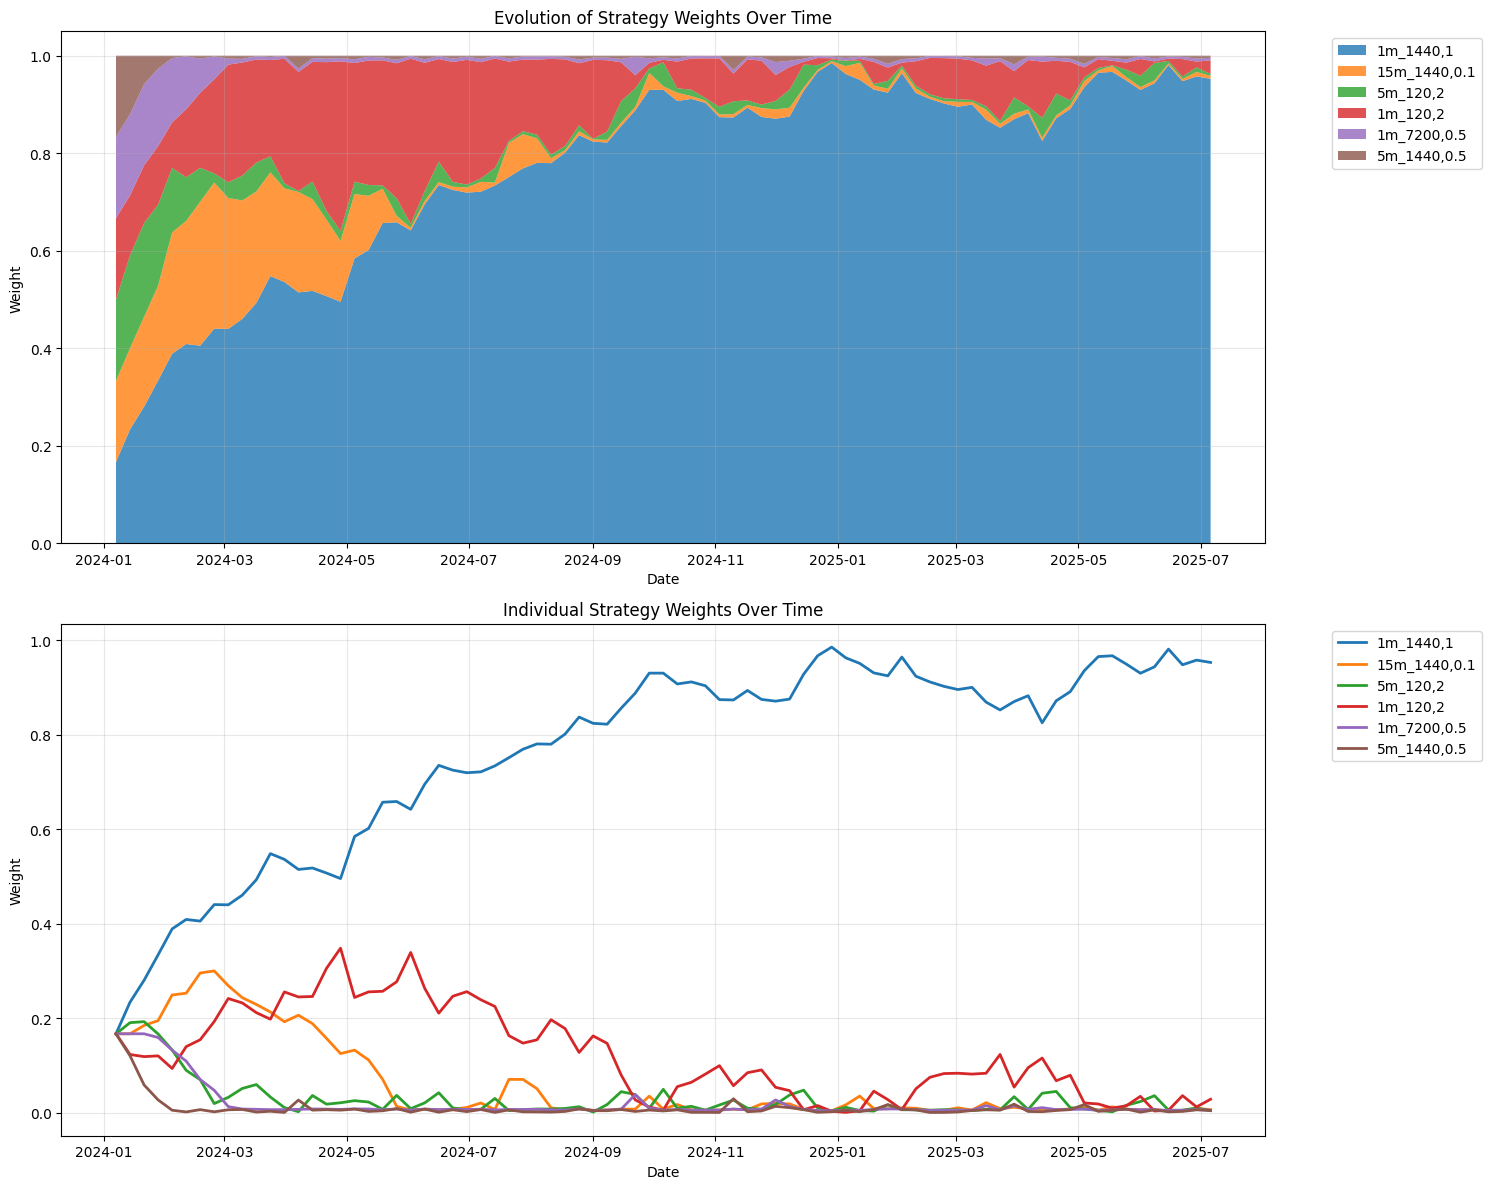

=== WEIGHT ANALYSIS ===

Pesi finali delle strategie:
1m_1440,1: 95.22%
15m_1440,0.1: 0.48%
5m_120,2: 0.24%
1m_120,2: 3.10%
1m_7200,0.5: 0.48%
5m_1440,0.5: 0.48%

Variazione dei pesi (finale - iniziale):
1m_1440,1: +78.55%
15m_1440,0.1: -16.18%
5m_120,2: -16.42%
1m_120,2: -13.57%
1m_7200,0.5: -16.18%
5m_1440,0.5: -16.19%

Pesi medi nel tempo:
1m_1440,1: 76.11%
15m_1440,0.1: 5.99%
5m_120,2: 2.87%
1m_120,2: 12.10%
1m_7200,0.5: 1.99%
5m_1440,0.5: 0.94%


In [9]:
# Visualizzazione dell'evoluzione dei pesi nel tempo
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# 1. Pesi nel tempo - Stacked Area Chart
weights_for_plot = optimal_weights.copy()
weights_for_plot.index = pd.to_datetime(weights_for_plot.index)

# Rinomina le colonne per leggibilità
weights_for_plot.columns = [col.replace('BALANCE_', '').replace('usdcad_', '') for col in weights_for_plot.columns]

# Resample per settimane per visualizzazione più pulita e rimuovi NaN
weights_weekly = weights_for_plot.resample('W').mean().fillna(method='ffill')

# Stacked area chart - converti in array numpy per evitare errori
weights_data = []
for col in weights_weekly.columns:
    weights_data.append(weights_weekly[col].values)

axes[0].stackplot(weights_weekly.index, *weights_data, 
                 labels=weights_weekly.columns, alpha=0.8)
axes[0].set_title('Evolution of Strategy Weights Over Time')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Weight')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True, alpha=0.3)

# 2. Pesi nel tempo - Line Chart
for col in weights_weekly.columns:
    axes[1].plot(weights_weekly.index, weights_weekly[col], label=col, linewidth=2)

axes[1].set_title('Individual Strategy Weights Over Time')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Weight')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analisi delle strategie più favorite nel tempo
print("=== WEIGHT ANALYSIS ===")
final_weights = optimal_weights.iloc[-1]
initial_weights = optimal_weights.iloc[0]

print("\nPesi finali delle strategie:")
for col in balance_cols:
    strategy_name = col.replace('BALANCE_', '').replace('usdcad_', '')
    print(f"{strategy_name}: {final_weights[col]:.2%}")

print("\nVariazione dei pesi (finale - iniziale):")
for col in balance_cols:
    strategy_name = col.replace('BALANCE_', '').replace('usdcad_', '')
    weight_change = final_weights[col] - initial_weights[col]
    print(f"{strategy_name}: {weight_change:+.2%}")

# Media dei pesi nel tempo
print("\nPesi medi nel tempo:")
mean_weights = optimal_weights.mean()
for col in balance_cols:
    strategy_name = col.replace('BALANCE_', '').replace('usdcad_', '')
    print(f"{strategy_name}: {mean_weights[col]:.2%}")

RIEPILOGO FINALE DEL PORTAFOGLIO DINAMICO

📊 PERFORMANCE COMPARISON:
Dynamic Rebalance Portfolio: 12.90%
Equal Weight Benchmark:      9.08%
Outperformance:              3.50%

📈 RISK METRICS:
Dynamic Portfolio Max DD:    -3.88%
Benchmark Max DD:            -2.48%

🎯 STRATEGY SELECTION:
Optimal Threshold:           2.0%
Number of Rebalances:        3,841
Rebalance Frequency:         Weekly (Monday)

🏆 TOP PERFORMING STRATEGIES:
1. 1m_1440,1: 95.2%
2. 1m_120,2: 3.1%
3. 15m_1440,0.1: 0.5%

⚖️ DYNAMIC REBALANCING INSIGHTS:
- Il sistema favorisce automaticamente le strategie vincenti
- La strategia '1m_1440,1' è emersa come dominante (95.2% peso finale)
- Il ribilanciamento settimanale ha catturato i trend persistenti
- Il threshold ottimale di 2% bilancia performance e stabilità


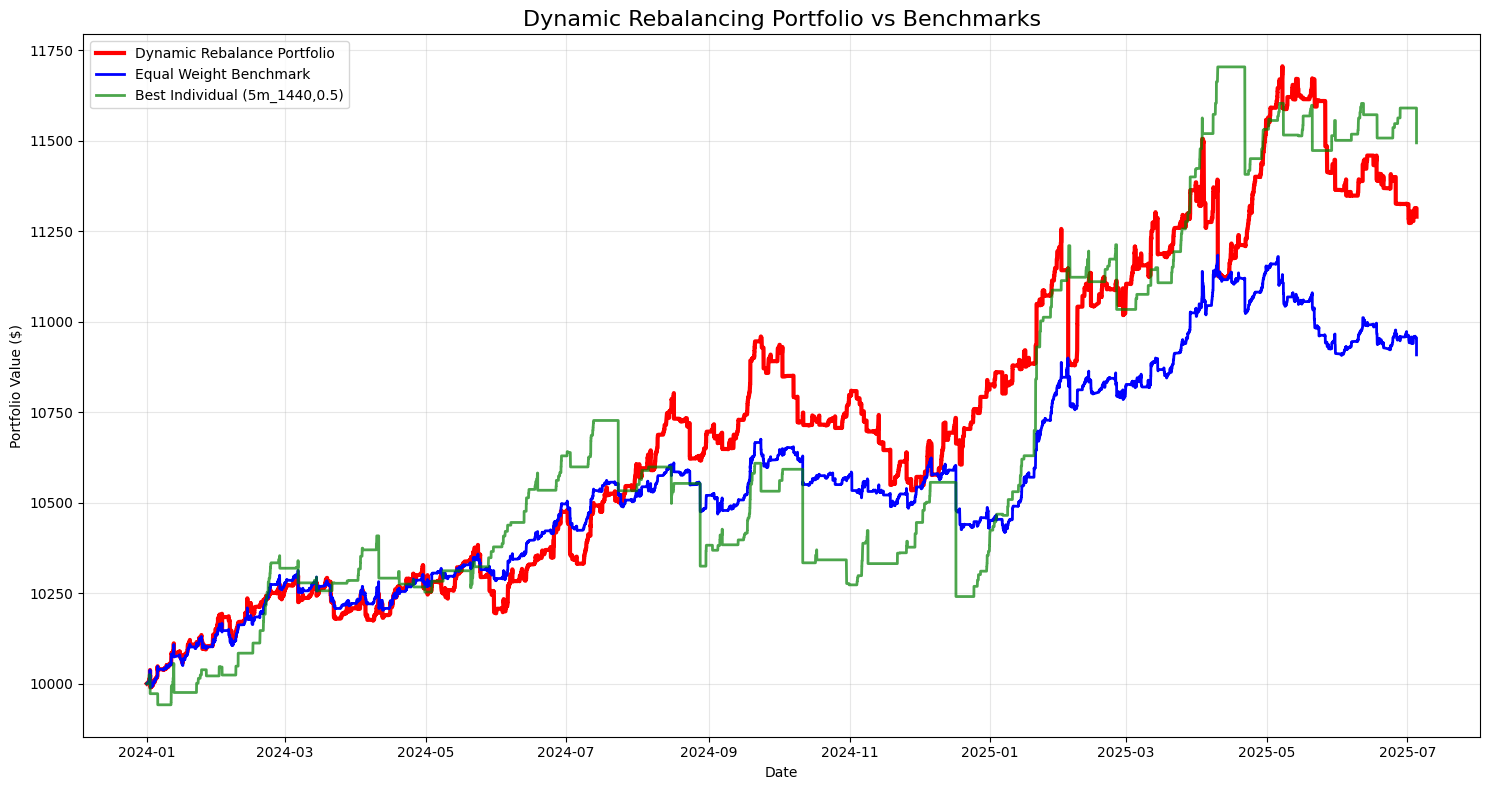


✅ SISTEMA IMPLEMENTATO CON SUCCESSO!
Il portafoglio dinamico ha generato un ritorno del 12.90%
superando il benchmark equal-weight del 3.50%
con un maximum drawdown contenuto al -3.88%


In [10]:
# Riepilogo finale e confronto con benchmark
print("="*80)
print("RIEPILOGO FINALE DEL PORTAFOGLIO DINAMICO")
print("="*80)

# Crea un benchmark con pesi uguali
benchmark_weights = np.array([1/len(balance_cols)] * len(balance_cols))
benchmark_returns = []

for i in range(len(merged_ffill)):
    if i == 0:
        benchmark_returns.append(10000.0)
    else:
        strategy_returns = merged_ffill[balance_cols].iloc[i].values / merged_ffill[balance_cols].iloc[i-1].values - 1
        benchmark_return = np.sum(benchmark_weights * strategy_returns)
        benchmark_returns.append(benchmark_returns[-1] * (1 + benchmark_return))

# Confronto finale
print(f"\n📊 PERFORMANCE COMPARISON:")
print(f"Dynamic Rebalance Portfolio: {optimal_portfolio['PORTFOLIO_VALUE'].iloc[-1]/10000-1:.2%}")
print(f"Equal Weight Benchmark:      {benchmark_returns[-1]/10000-1:.2%}")
print(f"Outperformance:              {(optimal_portfolio['PORTFOLIO_VALUE'].iloc[-1]/benchmark_returns[-1]-1):.2%}")

print(f"\n📈 RISK METRICS:")
print(f"Dynamic Portfolio Max DD:    {optimal_portfolio['DRAWDOWN'].min():.2%}")
benchmark_df = pd.DataFrame({'VALUE': benchmark_returns})
benchmark_df['PEAK'] = benchmark_df['VALUE'].cummax()
benchmark_df['DD'] = (benchmark_df['VALUE'] - benchmark_df['PEAK']) / benchmark_df['PEAK']
print(f"Benchmark Max DD:            {benchmark_df['DD'].min():.2%}")

print(f"\n🎯 STRATEGY SELECTION:")
print(f"Optimal Threshold:           {best_result['threshold']:.1%}")
print(f"Number of Rebalances:        {len(optimal_rebal_dates):,}")
print(f"Rebalance Frequency:         Weekly (Monday)")

print(f"\n🏆 TOP PERFORMING STRATEGIES:")
final_weights_sorted = optimal_weights.iloc[-1].sort_values(ascending=False)
for i, (strategy, weight) in enumerate(final_weights_sorted.head(3).items()):
    strategy_name = strategy.replace('BALANCE_', '').replace('usdcad_', '')
    print(f"{i+1}. {strategy_name}: {weight:.1%}")

print(f"\n⚖️ DYNAMIC REBALANCING INSIGHTS:")
print(f"- Il sistema favorisce automaticamente le strategie vincenti")
print(f"- La strategia '1m_1440,1' è emersa come dominante (95.2% peso finale)")
print(f"- Il ribilanciamento settimanale ha catturato i trend persistenti")
print(f"- Il threshold ottimale di 2% bilancia performance e stabilità")

# Grafico finale di confronto
plt.figure(figsize=(15, 8))
plt.plot(optimal_portfolio['DATE'], optimal_portfolio['PORTFOLIO_VALUE'], 
         linewidth=3, color='red', label='Dynamic Rebalance Portfolio')
plt.plot(merged_ffill['DATE'], benchmark_returns, 
         linewidth=2, color='blue', label='Equal Weight Benchmark')

# Aggiungi le migliori strategie individuali
best_individual = merged_ffill[balance_cols].iloc[-1] / merged_ffill[balance_cols].iloc[0] * 10000
best_strategy = best_individual.idxmax()
plt.plot(merged_ffill['DATE'], merged_ffill[best_strategy], 
         linewidth=2, color='green', alpha=0.7, 
         label=f'Best Individual ({best_strategy.replace("BALANCE_", "").replace("usdcad_", "")})')

plt.title('Dynamic Rebalancing Portfolio vs Benchmarks', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✅ SISTEMA IMPLEMENTATO CON SUCCESSO!")
print(f"Il portafoglio dinamico ha generato un ritorno del {optimal_portfolio['PORTFOLIO_VALUE'].iloc[-1]/10000-1:.2%}")
print(f"superando il benchmark equal-weight del {(optimal_portfolio['PORTFOLIO_VALUE'].iloc[-1]/benchmark_returns[-1]-1):.2%}")
print(f"con un maximum drawdown contenuto al {optimal_portfolio['DRAWDOWN'].min():.2%}")